# Data 622
## Assignment 5 - XGBoost Regressprs
Mark Ly

Student ID: 00504696

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics

# Loading and Splitting data
We will be using the Diabetes dataset in scikit-learn and will be splitting our data into 80% training and 20% testing.

In [3]:
diabetes = load_diabetes()
print(diabetes.feature_names)
print(diabetes.DESCR)

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides lev

In [5]:
X=diabetes['data']
y=diabetes['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning
Using 5 fold cross-validation, I will find the best parameters using _RandomizedSearchCV_ for the following parameters:
* _max depth_: 1 to 5; step of 1
* _learning rate_: 0.1 to 0.9; step of 0.1
* _n estimators_: 10 to 100; step of 10
* _reg alpha_: 0 to 1; step of 0.1
* _reg lambda_: 0 to 1; step of 0.1

This will be iterated 1000 times and the best parameters will be printed.

In [48]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

params = {
    'max_depth':range(1,6,1),
    'learning_rate':np.arange(0.1,1.0,0.1),
    'n_estimators':range(10,101,10),
    'reg_alpha':np.arange(0,1.1,0.1),
    'reg_lambda':np.arange(0,1.1,0.1)
}

rs_model=RandomizedSearchCV(XGBRegressor(eval_metric='mlogloss'),params,n_iter=1000,scoring='neg_mean_squared_error',
                            cv=5)
rs_model.fit(X_train, y_train)
print("Best Parameters:",rs_model.best_params_)

Best Parameters: {'reg_lambda': 0.1, 'reg_alpha': 0.8, 'n_estimators': 40, 'max_depth': 1, 'learning_rate': 0.1}


# Best Params & Training model
The results from the hyperparameter tuning using  _RandomizedSearchCV_, are:
* max_depth: 1
* learning_rate: 0.1
* n_estimators: 40
* reg_lambda: 0.1
* reg_alpha: 0.8

Using these parameters, we will train a XGBoost model on the entire training data and evaluate the model with mean
squared error and mean absolute error. I will also create a plot showing the feature importance from the trained model.

In [54]:
finalXGB = xgb.XGBRegressor(**rs_model.best_params_)
finalXGB.fit(X_train,y_train)
y_pred = finalXGB.predict(X_test)
print("MSE:", metrics.mean_squared_error(y_test,y_pred))
print("MAE:", metrics.mean_absolute_error(y_test,y_pred))

MSE: 2886.41391030266
MAE: 43.28254459140537


[0.         0.         0.3287189  0.18105473 0.         0.
 0.11465723 0.         0.30995065 0.06561847]


Text(0.5, 1.0, 'Diabetes Feature Importance')

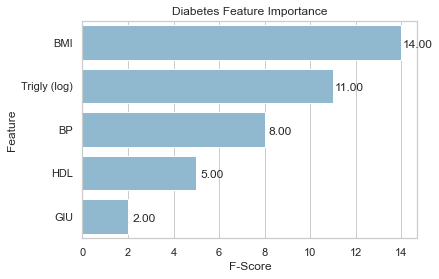

In [201]:
print(finalXGB.feature_importances_)

# getting f-score
feature_important= finalXGB.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

# creating a database
feature_data = pd.DataFrame(data=values, index=keys, columns=["f-score"]).sort_values(by="f-score", ascending=False)
feature_num =[2,8,3,6,9] # creating an index to use to extract feature names
feat_name = diabetes.feature_names

temp = []
for i in feature_num:
    temp.append(feat_name[i])

# replace the index of feature number with feature name
feature_data.set_axis(temp,inplace=True)

sns.set(style="whitegrid")
ax = sns.barplot(data=feature_data.T,orient="h",color='#86BBD8')
for p in ax.patches:
    width = p.get_width()
    plt.text(0.7+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.2f}'.format(width),
             ha='center', va='center')
ax.set_ylabel('Feature')
ax.set_xlabel('F-Score')
ax.set_yticklabels(['BMI','Trigly (log)','BP','HDL','GlU'])
ax.set_title('Diabetes Feature Importance')

# Results
Using the best parameters, {max_depth: 1, learning_rate: 0.1, n_estimators: 40, reg_lambda: 0.1, reg_alpha: 0.8}, we
trained a XGBoostRegressor to create the final trained model. We evaluated the model using mean squared error and
mean absolute error.
* Mean Squared Error: 2886.41
* Mean Absolute Error: 43.28

From the feature selection chart, out of the 10 initial features, 5 of them are important features.
* BMI; F-Score = 14
* Triglyceride (log); F-Score = 11
* Blood Pressure; F-Score = 8
* HDL; F-Score = 5
* Glucose; F-Score = 2.0

In [6]:
for i in X:
    print(i)


[ 0.03807591  0.05068012  0.06169621  0.02187235 -0.0442235  -0.03482076
 -0.04340085 -0.00259226  0.01990842 -0.01764613]
[-0.00188202 -0.04464164 -0.05147406 -0.02632783 -0.00844872 -0.01916334
  0.07441156 -0.03949338 -0.06832974 -0.09220405]
[ 0.08529891  0.05068012  0.04445121 -0.00567061 -0.04559945 -0.03419447
 -0.03235593 -0.00259226  0.00286377 -0.02593034]
[-0.08906294 -0.04464164 -0.01159501 -0.03665645  0.01219057  0.02499059
 -0.03603757  0.03430886  0.02269202 -0.00936191]
[ 0.00538306 -0.04464164 -0.03638469  0.02187235  0.00393485  0.01559614
  0.00814208 -0.00259226 -0.03199144 -0.04664087]
[-0.09269548 -0.04464164 -0.04069594 -0.01944209 -0.06899065 -0.07928784
  0.04127682 -0.0763945  -0.04118039 -0.09634616]
[-0.04547248  0.05068012 -0.04716281 -0.01599922 -0.04009564 -0.02480001
  0.00077881 -0.03949338 -0.06291295 -0.03835666]
[ 0.06350368  0.05068012 -0.00189471  0.06662967  0.09061988  0.10891438
  0.02286863  0.01770335 -0.03581673  0.00306441]
[ 0.04170844  0.